In [193]:
import kumoai.experimental.rfm as rfm, os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [194]:
home_api_key_file = Path.home() / "kumoai_key.txt"
with open(home_api_key_file, "r") as file:
    api_key = file.read().strip()
os.environ["KUMO_API_KEY"] = api_key

rfm.init()

Client has already been created. To re-initialize Kumo, please start a new interpreter. No changes will be made to the current session.


# Exercise

- Create a synthetic dataset with the purpose of testing how KumoRFM deals with temporal dependency that is not in the transactional history, but instead is in a "user type" variable that changes over time.
- Essentially, there are users of 2 types: premium/free. Premium users can do actions that free users cannot.
- The exercise is about testing if KumoRFM detects this dependency and considers it in predictions.

### Dataset description
- Create a synthetic dataset representing users of 2 types (tier free or tier premium), uploading files of different sizes, and with their user tiers changing over time.
- While on Premium tier, users can upload any size. 
- While on free tier, users can upload files below 10GB. 
- For simplicity, there are only 2 sizes: 5GB and 50GB.
- Users can change their tier no earlier than 24 hours after the last change. 
- There are 50 users, covering 5 cohorts:
    - Always premium (unknown start) → a single interval that spans the whole window.
    - Always free → a single interval that spans the whole window.
    - Premium → Free once (≥24h after start).
    - Free → Premium once (≥24h).
    - Free → Premium → Free (each change ≥24h apart; all within window).
- The history of transactions lasts 10 days from March 1st to March 10th, 2025.
- The prediction tasks will be done for different users, predicting their likelihood that they will upload a 50GB file in the next hour.
- Expectations: 
    - For users that just became free tier this should be 0.
    - For users that just became Premium it should >> 0.

### Tables

- users (50 users). This set is just random ids and names.
    - user_id (PK)
    - name

- items (80 different items: 45 of 5 GB, 35 of 50 GB). Basically random ids.
    - item_id (PK)
    - size_gb in {5, 50}

- tiers. See creation process below.
    - tier_status_id (PK)
    - user_id (FK -> users.user_id)
    - from_datetime
    - until_datetime
    - status in {'free', 'premium'}


- uploads. See creation process below.
    - upload_id (PK)
    - user_id (FK -> users.user_id)
    - item_id (FK -> items.item_id)
    - datetime


### Creation process (not efficient, prioritize simplicity/clarity)

- tiers:
    - User ids from 1 to 10: always premium: 1 row in tiers.
        - from_date = START, until_date = END, status = 'premium'
    - User ids from 11 to 20: always free: 1 row in tiers.
        - from_date = START, until_date = END: status = 'free'    
    - User ids from 21 to 30: premium to free: 2 rows in tiers.
        - Take a random date X in (START, END)
        - from_date = START, until_date = X: status = 'premium'
        - from_date = X, until_date = END: status = 'free'
    - user ids from 31 to 40: free to premium: 2 rows in tiers.
        - Take a random date X in (START, END)
        - from_date = START, until_date = X: status = 'free'
        - from_date = X, until_date = END: status = 'premium'
    - user ids from 41 to 50: free to premium to free: 3 rows in tiers.
        - Take random dates X1 < X2 in (START, END)
        - from_date = START, until_date = X1: status = 'free'
        - from_date = X1, until_date = X2: status = 'premium'
        - from_date = X2, until_date = END: status = 'free'

- uploads:
    - for each tier_status_id, create the uploads in the corresponding interval.
    - Given a tier_status_id, get the details: user_id, from_date, until_date, status.
    - If status = 'free':
        - compute the number of hours delta_h from from_date to until_date.
        - take a sample of r = ceil(delta_h/10) times in (from_date, until_date).
        - use those as datetime.
        - generate the corresponding number of rows for uploads.
        - keep track of the last generated upload_id.
        - the user_id is the current one.
        - items_id's should be taken at random from those with 5GB.
    - if status = 'premium':
        - Do the same as for free users (5GB files).
        - Then repeat but for 50GB files.


In [195]:
import csv
import math
import random
from datetime import datetime, timedelta, timezone
import pandas as pd  # you used pd.Timestamp below; keeping it

# ----------------------------
# Config
# ----------------------------
SEED = 42
random.seed(SEED)

START = datetime(2025, 3, 1, 0, 0, 0, tzinfo=timezone.utc)
END   = datetime(2025, 3, 11, 0, 0, 0, tzinfo=timezone.utc)  # half-open [START, END)

USERS_CSV   = "users.csv"
ITEMS_CSV   = "items.csv"
TIERS_CSV   = "tiers.csv"
UPLOADS_CSV = "uploads.csv"

N_USERS = 50
N_ITEMS_5GB = 45
N_ITEMS_50GB = 35

# Poisson rates (uploads per hour)
L_FREE_5_PER_HR   = 0.1   # replaces ceil(delta_h/10.0)
L_PREM_5_PER_HR   = 0.1
L_PREM_50_PER_HR  = 0.1

# ----------------------------
# Helpers
# ----------------------------
def rand_dt(a, b):
    total_sec = int((b - a).total_seconds())
    if total_sec <= 1:
        return a + timedelta(seconds=1)
    off = random.randint(1, total_sec - 1)
    return a + timedelta(seconds=off)

def sample_times(n, a, b):
    return [rand_dt(a, b) for _ in range(n)]

def hours_between(a, b):
    return (b - a).total_seconds() / 3600.0

def poisson(lam):
    # Knuth's algorithm (stdlib-only Poisson sampler)
    # Good for modest lam; fine here.
    L = math.exp(-lam)
    k = 0
    p = 1.0
    while True:
        k += 1
        p *= random.random()
        if p <= L:
            return k - 1

# ----------------------------
# 1) users
# ----------------------------
users = []
for uid in range(1, N_USERS + 1):
    users.append([uid, f"User {uid:03d}"])

# ----------------------------
# 2) items
# ----------------------------
items = []
for iid in range(1, N_ITEMS_5GB + 1):
    items.append([iid, 5])
for iid in range(N_ITEMS_5GB + 1, N_ITEMS_5GB + N_ITEMS_50GB + 1):
    items.append([iid, 50])

item_ids_5 = [row[0] for row in items if row[1] == 5]
item_ids_50 = [row[0] for row in items if row[1] == 50]

# ----------------------------
# 3) tiers
# ----------------------------
tiers = []
tier_status_id = 1

def add_interval(uid, a, b, status):
    global tier_status_id
    tiers.append([tier_status_id, uid, a, b, status])
    tier_status_id += 1

# always premium
for uid in range(1, 11):
    add_interval(uid, START, END, "premium")

# always free
for uid in range(11, 21):
    add_interval(uid, START, END, "free")

# premium -> free
for uid in range(21, 31):
    lo = START + timedelta(hours=24)
    hi = END - timedelta(hours=24)
    x = lo + timedelta(seconds=random.randint(0, int((hi - lo).total_seconds())))
    add_interval(uid, START, x, "premium")
    add_interval(uid, x, END, "free")

# free -> premium
for uid in range(31, 41):
    lo = START + timedelta(hours=24)
    hi = END - timedelta(hours=24)
    x = lo + timedelta(seconds=random.randint(0, int((hi - lo).total_seconds())))
    add_interval(uid, START, x, "free")
    add_interval(uid, x, END, "premium")

# free -> premium -> free
for uid in range(41, 51):
    lo1 = START + timedelta(hours=24)
    hi1 = END - timedelta(hours=48)
    x1 = lo1 + timedelta(seconds=random.randint(0, int((hi1 - lo1).total_seconds())))

    lo2 = x1 + timedelta(hours=24)
    hi2 = END - timedelta(seconds=1)
    if lo2 >= hi2:
        hi2 = x1 + timedelta(hours=48)
    x2 = lo2 + timedelta(seconds=random.randint(0, int((hi2 - lo2).total_seconds())))

    add_interval(uid, START, x1, "free")
    add_interval(uid, x1, x2, "premium")
    add_interval(uid, x2, END, "free")

# ----------------------------
# 4) uploads (now using Poisson counts)
# ----------------------------
uploads = []
upload_id = 1

for row in tiers:
    uid = row[1]
    a = row[2]
    b = row[3]
    status = row[4]

    delta_h = hours_between(a, b)
    if delta_h <= 0:
        continue

    if status == "free":
        # old: r = ceil(delta_h / 10.0)
        n5 = poisson(L_FREE_5_PER_HR * delta_h)
        for t in sample_times(n5, a, b):
            uploads.append([upload_id, uid, random.choice(item_ids_5), t])
            upload_id += 1

    if status == "premium":
        # 5GB stream
        n5 = poisson(L_PREM_5_PER_HR * delta_h)
        for t in sample_times(n5, a, b):
            uploads.append([upload_id, uid, random.choice(item_ids_5), t])
            upload_id += 1

        # 50GB stream (no burst)
        n50 = poisson(L_PREM_50_PER_HR * delta_h)
        for t in sample_times(n50, a, b):
            uploads.append([upload_id, uid, random.choice(item_ids_50), t])
            upload_id += 1

# ----------------------------
# Write CSVs
# ----------------------------
with open(USERS_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["user_id", "name"])
    w.writerows(users)

with open(ITEMS_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["item_id", "size_gb"])
    w.writerows(items)

with open(TIERS_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["tier_status_id", "user_id", "from_datetime", "until_datetime", "status"])
    for tr in tiers:
        w.writerow([
            tr[0],
            tr[1],
            pd.Timestamp(tr[2]).tz_localize(None),  # or tr[2].strftime("%Y-%m-%dT%H:%M:%SZ")
            pd.Timestamp(tr[3]).tz_localize(None),  # or tr[3].strftime("%Y-%m-%dT%H:%M:%SZ")
            tr[4]
        ])

with open(UPLOADS_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["upload_id", "user_id", "item_id", "datetime"])
    for up in uploads:
        w.writerow([
            up[0],
            up[1],
            up[2],
            pd.Timestamp(up[3]).tz_localize(None),  # or up[3].strftime("%Y-%m-%dT%H:%M:%SZ")
        ])

print("Done. Wrote:", USERS_CSV, ITEMS_CSV, TIERS_CSV, UPLOADS_CSV)


Done. Wrote: users.csv items.csv tiers.csv uploads.csv


In [196]:
users_df = pd.read_csv(USERS_CSV)
tiers_df = pd.read_csv(TIERS_CSV)
items_df = pd.read_csv(ITEMS_CSV)
uploads_df = pd.read_csv(UPLOADS_CSV)

In [197]:
#uploads_df = uploads_df.merge(items_df)

In [198]:
display(users_df.head(3))
display(tiers_df.head(3))
display(items_df.head(3))
display(uploads_df.head(3))


,user_id,name
0,1,User 001
1,2,User 002
2,3,User 003


,tier_status_id,user_id,from_datetime,until_datetime,status
0,1,1,2025-03-01 00:00:00,2025-03-11 00:00:00,premium
1,2,2,2025-03-01 00:00:00,2025-03-11 00:00:00,premium
2,3,3,2025-03-01 00:00:00,2025-03-11 00:00:00,premium


,item_id,size_gb
0,1,5
1,2,5
2,3,5


,upload_id,user_id,item_id,datetime
0,1,1,15,2025-03-04 05:45:47
1,2,1,3,2025-03-09 12:25:12
2,3,1,21,2025-03-09 07:05:52


In [199]:
print(users_df.shape[0], users_df['user_id'].nunique())
print(tiers_df.shape[0], tiers_df['tier_status_id'].nunique())
print(items_df.shape[0], items_df['item_id'].nunique())
print(uploads_df.shape[0], uploads_df['upload_id'].nunique())


50 50
90 90
80 80
1781 1781


In [200]:
def plot_user_uploads(tiers_df, uploads_df, items_df, user_id, title=None):
    # Ensure datetime dtype
    tiers = tiers_df.loc[tiers_df.user_id == user_id].copy()
    tiers["from_datetime"] = pd.to_datetime(tiers["from_datetime"])
    tiers["until_datetime"] = pd.to_datetime(tiers["until_datetime"])

    uploads = uploads_df.loc[uploads_df.user_id == user_id].copy()
    uploads["datetime"] = pd.to_datetime(uploads["datetime"])

    # Join to get size_gb for y-axis
    items_small = items_df[["item_id", "size_gb"]].copy()
    uploads = uploads.merge(items_small, on="item_id", how="left")    

    # Set x-limits from tier coverage (fallback to upload range if needed)
    if not tiers.empty:
        xmin = tiers["from_datetime"].min()
        xmax = tiers["until_datetime"].max()
    else:
        xmin = uploads["datetime"].min()
        xmax = uploads["datetime"].max()

    # Plot
    fig, ax = plt.subplots(figsize=(10, 3.5))

    # Background: tier intervals
    # (label only once to keep legend clean)
    added_free = False
    added_premium = False
    for _, r in tiers.sort_values("from_datetime").iterrows():
        color = "green" if r["status"] == "free" else "blue"
        label = None
        if r["status"] == "free" and not added_free:
            label = "free"
            added_free = True
        if r["status"] == "premium" and not added_premium:
            label = "premium"
            added_premium = True
        ax.axvspan(r["from_datetime"], r["until_datetime"], color=color, alpha=0.15, label=label)

    # Upload points at y = 5 or 50
    if not uploads.empty:
        ax.scatter(uploads["datetime"], uploads["size_gb"], s=25, zorder=3)

    # Axes, labels, ticks
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(0, 55)
    ax.set_yticks([5, 50])
    ax.set_xlabel("time")
    ax.set_ylabel("GB")

    if title is None:
        title = f"User {user_id} uploads"
    ax.set_title(title)

    # Legend (only if any tier intervals exist)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(loc="upper left")

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


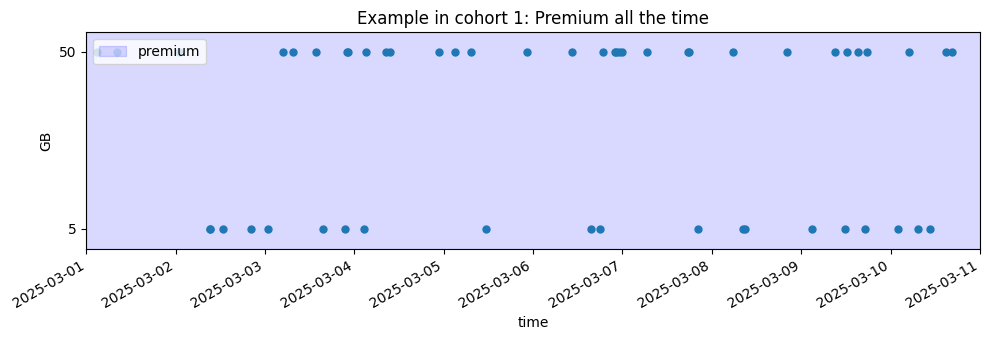

In [201]:
plot_user_uploads(tiers_df, uploads_df, items_df, 5, "Example in cohort 1: Premium all the time")

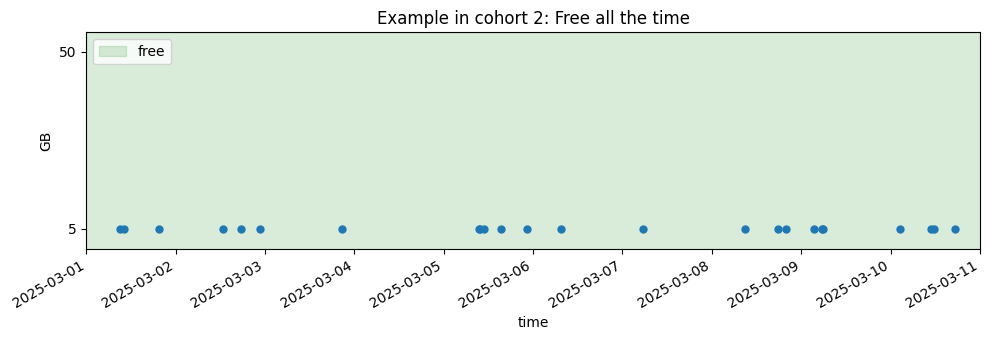

In [202]:
plot_user_uploads(tiers_df, uploads_df, items_df, 15, "Example in cohort 2: Free all the time")

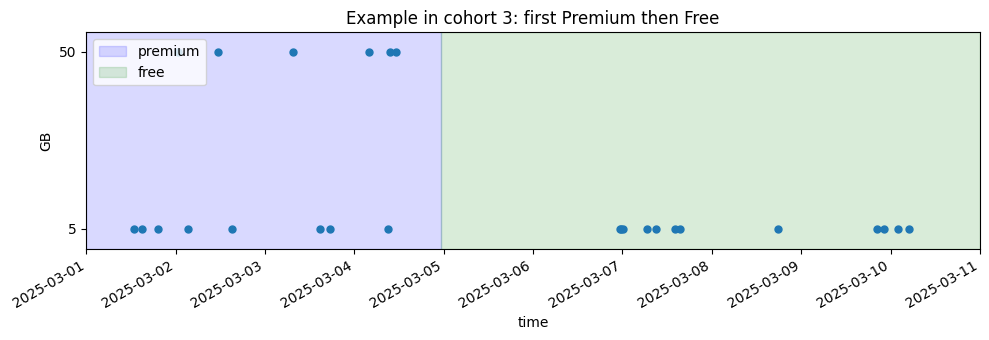

In [203]:
plot_user_uploads(tiers_df, uploads_df, items_df, 25, "Example in cohort 3: first Premium then Free")

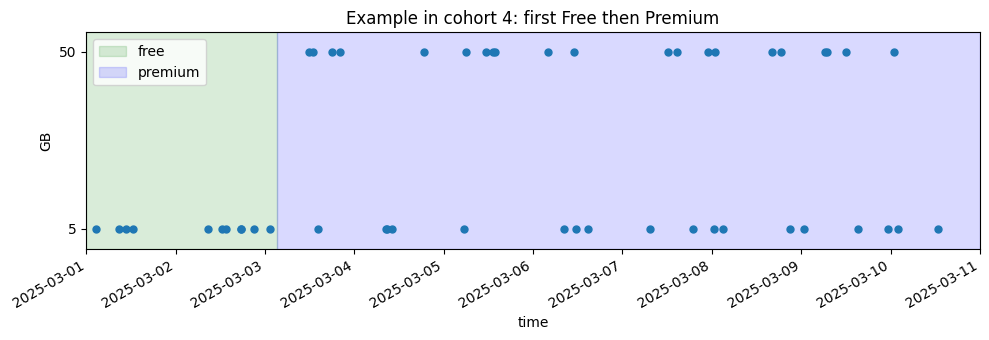

In [204]:
plot_user_uploads(tiers_df, uploads_df, items_df, 35, "Example in cohort 4: first Free then Premium")

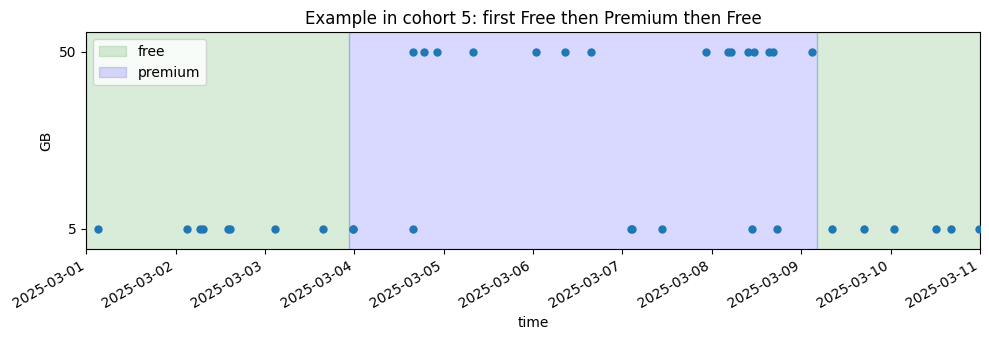

In [205]:
plot_user_uploads(tiers_df, uploads_df, items_df, 45, "Example in cohort 5: first Free then Premium then Free")

In [206]:
display(users_df.head(3))
display(tiers_df.head(3))
display(items_df.head(3))
display(uploads_df.head(3))

,user_id,name
0,1,User 001
1,2,User 002
2,3,User 003


,tier_status_id,user_id,from_datetime,until_datetime,status
0,1,1,2025-03-01 00:00:00,2025-03-11 00:00:00,premium
1,2,2,2025-03-01 00:00:00,2025-03-11 00:00:00,premium
2,3,3,2025-03-01 00:00:00,2025-03-11 00:00:00,premium


,item_id,size_gb
0,1,5
1,2,5
2,3,5


,upload_id,user_id,item_id,datetime
0,1,1,15,2025-03-04 05:45:47
1,2,1,3,2025-03-09 12:25:12
2,3,1,21,2025-03-09 07:05:52


In [207]:
users = rfm.LocalTable(users_df, name="users").infer_metadata()
tiers = rfm.LocalTable(tiers_df, name="tiers").infer_metadata()
items = rfm.LocalTable(items_df, name="items").infer_metadata()
uploads = rfm.LocalTable(uploads_df, name="uploads").infer_metadata()


Detected primary key 'user_id' in table 'users'
Detected time column 'from_datetime' in table 'tiers'
Detected primary key 'item_id' in table 'items'
Detected primary key 'upload_id' and time column 'datetime' in table 'uploads'


In [208]:
users.print_metadata()

### 🏷️ Metadata of Table `users` (50 rows)

name,dtype,stype,is_primary_key,is_time_column
user_id,int,ID,True,False
name,string,text,False,False


In [209]:
tiers.primary_key = "tier_status_id"
tiers.print_metadata()

### 🏷️ Metadata of Table `tiers` (90 rows)

name,dtype,stype,is_primary_key,is_time_column
tier_status_id,int,ID,True,False
user_id,int,ID,False,False
from_datetime,string,timestamp,False,True
until_datetime,string,timestamp,False,False
status,string,categorical,False,False


In [210]:
items['size_gb'].stype = "numerical"
items.print_metadata()

### 🏷️ Metadata of Table `items` (80 rows)

name,dtype,stype,is_primary_key,is_time_column
item_id,int,ID,True,False
size_gb,int,numerical,False,False


In [211]:
#uploads['size_gb'].stype = "numerical"
uploads.print_metadata()

### 🏷️ Metadata of Table `uploads` (1,781 rows)

name,dtype,stype,is_primary_key,is_time_column
upload_id,int,ID,True,False
user_id,int,ID,False,False
item_id,int,ID,False,False
datetime,string,timestamp,False,True


In [212]:
graph = rfm.LocalGraph(tables=[users, tiers, items, uploads])

In [213]:
graph.link(src_table="tiers", fkey="user_id", dst_table="users");
graph.link(src_table="uploads", fkey="item_id", dst_table="items");
graph.link(src_table="uploads", fkey="user_id", dst_table="users");
graph.print_links()

### 🕸️ Graph Links (FK ↔️ PK)

- `uploads.item_id` ↔️ `items.item_id`
- `tiers.user_id` ↔️ `users.user_id`
- `uploads.user_id` ↔️ `users.user_id`

In [214]:
model = rfm.KumoRFM(graph, verbose=False)

<div align="center">
  <img src="temporal_dependencies_01.png" width="800" />
</div>

In [215]:
query = """PREDICT COUNT(uploads.* where items.size_gb=50, 0, 5, hours)>0 FOR users.user_id = 5"""
model.predict(query, anchor_time=pd.Timestamp("2025-03-02"), verbose=False)

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

# ADD SIZE_GB TO UPLOADS (and ignore items)

In [274]:
def get_details_by_user(uid, hours1, hours2, nhops=2):
    print(f"User: {uid}")
    one_user_tiers = tiers_df.loc[tiers_df.user_id==uid]
    for _, r in one_user_tiers.iterrows():
        uid = r['user_id']
        from_datetime_plus = pd.Timestamp(r['from_datetime']) + timedelta(hours=hours1)
        until_datetime_minus = pd.Timestamp(r['until_datetime']) - timedelta(hours=hours1)
        middle_datetime = from_datetime_plus + (until_datetime_minus - from_datetime_plus)/2
        status = r['status']
        if status == 'free':
            actual_prob = 0
        else:
            actual_prob = 1 - math.exp(-hours2*0.1)
        print("====================================")
        print(f"User: {uid}. Status: {status}")
        query = f"""PREDICT COUNT(uploads.* where uploads.size_gb=50, 0, {hours2}, hours)>0 FOR users.user_id = {uid}"""
        pred_df = model.predict(query, anchor_time=from_datetime_plus, verbose=False, num_hops=nhops)
        print(f"     Anchor time: {from_datetime_plus}. Prob 50GB upload within next {hours2} hours: {pred_df['True_PROB'].iloc[0]}. Actual: {actual_prob}")
        pred_df = model.predict(query, anchor_time=middle_datetime, verbose=False, num_hops=nhops)
        print(f"     Anchor time: {middle_datetime}. Prob 50GB upload within next {hours2} hours: {pred_df['True_PROB'].iloc[0]}. Actual: {actual_prob}")
        pred_df = model.predict(query, anchor_time=until_datetime_minus, verbose=False, num_hops=nhops)
        print(f"     Anchor time: {until_datetime_minus}. Prob 50GB upload within next {hours2} hours: {pred_df['True_PROB'].iloc[0]}. Actual: {actual_prob}")

In [275]:
users_df = pd.read_csv(USERS_CSV)
tiers_df = pd.read_csv(TIERS_CSV)
items_df = pd.read_csv(ITEMS_CSV)
uploads_df = pd.read_csv(UPLOADS_CSV)

uploads_df = uploads_df.merge(items_df)

In [276]:
display(users_df.head(3))
display(tiers_df.head(3))
display(uploads_df.head(3))


,user_id,name
0,1,User 001
1,2,User 002
2,3,User 003


,tier_status_id,user_id,from_datetime,until_datetime,status
0,1,1,2025-03-01 00:00:00,2025-03-11 00:00:00,premium
1,2,2,2025-03-01 00:00:00,2025-03-11 00:00:00,premium
2,3,3,2025-03-01 00:00:00,2025-03-11 00:00:00,premium


,upload_id,user_id,item_id,datetime,size_gb
0,1,1,15,2025-03-04 05:45:47,5
1,2,1,3,2025-03-09 12:25:12,5
2,3,1,21,2025-03-09 07:05:52,5


In [277]:
users = rfm.LocalTable(users_df, name="users").infer_metadata()
tiers = rfm.LocalTable(tiers_df, name="tiers").infer_metadata()
#items = rfm.LocalTable(items_df, name="items").infer_metadata()
uploads = rfm.LocalTable(uploads_df, name="uploads").infer_metadata()


Detected primary key 'user_id' in table 'users'
Detected time column 'from_datetime' in table 'tiers'
Detected primary key 'upload_id' and time column 'datetime' in table 'uploads'


In [278]:
users.print_metadata()

### 🏷️ Metadata of Table `users` (50 rows)

name,dtype,stype,is_primary_key,is_time_column
user_id,int,ID,True,False
name,string,text,False,False


In [279]:
tiers.primary_key = "tier_status_id"
tiers.print_metadata()

### 🏷️ Metadata of Table `tiers` (90 rows)

name,dtype,stype,is_primary_key,is_time_column
tier_status_id,int,ID,True,False
user_id,int,ID,False,False
from_datetime,string,timestamp,False,True
until_datetime,string,timestamp,False,False
status,string,categorical,False,False


In [280]:
# items['size_gb'].stype = "numerical"
# items.print_metadata()

In [281]:
uploads['size_gb'].stype = "numerical"
uploads.print_metadata()

### 🏷️ Metadata of Table `uploads` (1,781 rows)

name,dtype,stype,is_primary_key,is_time_column
upload_id,int,ID,True,False
user_id,int,ID,False,False
item_id,int,ID,False,False
datetime,string,timestamp,False,True
size_gb,int,numerical,False,False


In [282]:
graph = rfm.LocalGraph(tables=[users, tiers, uploads])

In [283]:
graph.link(src_table="tiers", fkey="user_id", dst_table="users");
#graph.link(src_table="uploads", fkey="item_id", dst_table="items");
graph.link(src_table="uploads", fkey="user_id", dst_table="users");
graph.print_links()

### 🕸️ Graph Links (FK ↔️ PK)

- `tiers.user_id` ↔️ `users.user_id`
- `uploads.user_id` ↔️ `users.user_id`

In [284]:
model = rfm.KumoRFM(graph, verbose=False)

<div align="center">
  <img src="temporal_dependencies_02_new.png" width="800" />
</div>

### Look at probabilities for specific users in each cohort, in all their tiers, at different times.

In [285]:
get_details_by_user(uid=5, hours1=12, hours2=1)
get_details_by_user(uid=5, hours1=12, hours2=3)
get_details_by_user(uid=5, hours1=12, hours2=6)


User: 5
User: 5. Status: premium
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 1 hours: 0.0863855332. Actual: 0.09516258196404048
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 1 hours: 0.0706980154. Actual: 0.09516258196404048
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 1 hours: 0.0837932974. Actual: 0.09516258196404048
User: 5
User: 5. Status: premium
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 3 hours: 0.2414897382. Actual: 0.2591817793182821
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 3 hours: 0.2899141014. Actual: 0.2591817793182821
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 3 hours: 0.3081088066. Actual: 0.2591817793182821
User: 5
User: 5. Status: premium
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 6 hours: 0.334677726. Actual: 0.4511883639059736
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 6 hou

In [286]:
get_details_by_user(uid=15, hours1=12, hours2=1)
get_details_by_user(uid=15, hours1=12, hours2=3)
get_details_by_user(uid=15, hours1=12, hours2=6)

User: 15
User: 15. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 1 hours: 0.0117250606. Actual: 0
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 1 hours: 0.0125435479. Actual: 0
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 1 hours: 0.0301833302. Actual: 0
User: 15
User: 15. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 3 hours: 0.0328520611. Actual: 0
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 3 hours: 0.0010885127. Actual: 0
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 3 hours: 0.0488944016. Actual: 0
User: 15
User: 15. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 6 hours: 0.0709848031. Actual: 0
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 6 hours: 0.0096317418. Actual: 0
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 6 hours: 0.067527473. Actual

In [287]:
get_details_by_user(uid=25, hours1=12, hours2=1)
get_details_by_user(uid=25, hours1=12, hours2=3)
get_details_by_user(uid=25, hours1=12, hours2=6)

User: 25
User: 25. Status: premium
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 1 hours: 0.0900935158. Actual: 0.09516258196404048
     Anchor time: 2025-03-02 23:39:53.500000. Prob 50GB upload within next 1 hours: 0.1209282428. Actual: 0.09516258196404048
     Anchor time: 2025-03-04 11:19:47. Prob 50GB upload within next 1 hours: 0.1456751972. Actual: 0.09516258196404048
User: 25. Status: free
     Anchor time: 2025-03-05 11:19:47. Prob 50GB upload within next 1 hours: 0.0464597307. Actual: 0
     Anchor time: 2025-03-07 23:39:53.500000. Prob 50GB upload within next 1 hours: 0.025803322. Actual: 0
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 1 hours: 0.0198469553. Actual: 0
User: 25
User: 25. Status: premium
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 3 hours: 0.2429694831. Actual: 0.2591817793182821
     Anchor time: 2025-03-02 23:39:53.500000. Prob 50GB upload within next 3 hours: 0.2661077678. Actual: 0.25918177

In [288]:
get_details_by_user(uid=35, hours1=12, hours2=1)
get_details_by_user(uid=35, hours1=12, hours2=3)
get_details_by_user(uid=35, hours1=12, hours2=6)

User: 35
User: 35. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 1 hours: 0.0110988514. Actual: 0
     Anchor time: 2025-03-02 01:38:43. Prob 50GB upload within next 1 hours: 0.0004689481. Actual: 0
     Anchor time: 2025-03-02 15:17:26. Prob 50GB upload within next 1 hours: 0.0014247391. Actual: 0
User: 35. Status: premium
     Anchor time: 2025-03-03 15:17:26. Prob 50GB upload within next 1 hours: 0.1233185902. Actual: 0.09516258196404048
     Anchor time: 2025-03-07 01:38:43. Prob 50GB upload within next 1 hours: 0.0694787502. Actual: 0.09516258196404048
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 1 hours: 0.0534602068. Actual: 0.09516258196404048
User: 35
User: 35. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 3 hours: 0.0386992209. Actual: 0
     Anchor time: 2025-03-02 01:38:43. Prob 50GB upload within next 3 hours: 0.0022416147. Actual: 0
     Anchor time: 2025-03-02 15:17:26. Prob 50GB

In [289]:
get_details_by_user(uid=45, hours1=12, hours2=1)
get_details_by_user(uid=45, hours1=12, hours2=3)
get_details_by_user(uid=45, hours1=12, hours2=6)

User: 45
User: 45. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 1 hours: 0.0059792544. Actual: 0
     Anchor time: 2025-03-02 11:15:07. Prob 50GB upload within next 1 hours: 0.0005295747. Actual: 0
     Anchor time: 2025-03-03 10:30:14. Prob 50GB upload within next 1 hours: 0.0082582859. Actual: 0
User: 45. Status: premium
     Anchor time: 2025-03-04 10:30:14. Prob 50GB upload within next 1 hours: 0.0130184665. Actual: 0.09516258196404048
     Anchor time: 2025-03-06 13:20:27. Prob 50GB upload within next 1 hours: 0.1036657393. Actual: 0.09516258196404048
     Anchor time: 2025-03-08 16:10:40. Prob 50GB upload within next 1 hours: 0.1486973464. Actual: 0.09516258196404048
User: 45. Status: free
     Anchor time: 2025-03-09 16:10:40. Prob 50GB upload within next 1 hours: 0.0716863498. Actual: 0
     Anchor time: 2025-03-10 02:05:20. Prob 50GB upload within next 1 hours: 0.053371124. Actual: 0
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload wi

# INCREASE HOPS

In [290]:
users_df = pd.read_csv(USERS_CSV)
tiers_df = pd.read_csv(TIERS_CSV)
items_df = pd.read_csv(ITEMS_CSV)
uploads_df = pd.read_csv(UPLOADS_CSV)

uploads_df = uploads_df.merge(items_df)

In [291]:
display(users_df.head(3))
display(tiers_df.head(3))
#display(items_df.head(3))
display(uploads_df.head(3))


,user_id,name
0,1,User 001
1,2,User 002
2,3,User 003


,tier_status_id,user_id,from_datetime,until_datetime,status
0,1,1,2025-03-01 00:00:00,2025-03-11 00:00:00,premium
1,2,2,2025-03-01 00:00:00,2025-03-11 00:00:00,premium
2,3,3,2025-03-01 00:00:00,2025-03-11 00:00:00,premium


,upload_id,user_id,item_id,datetime,size_gb
0,1,1,15,2025-03-04 05:45:47,5
1,2,1,3,2025-03-09 12:25:12,5
2,3,1,21,2025-03-09 07:05:52,5


In [292]:
users = rfm.LocalTable(users_df, name="users").infer_metadata()
tiers = rfm.LocalTable(tiers_df, name="tiers").infer_metadata()
#items = rfm.LocalTable(items_df, name="items").infer_metadata()
uploads = rfm.LocalTable(uploads_df, name="uploads").infer_metadata()


Detected primary key 'user_id' in table 'users'
Detected time column 'from_datetime' in table 'tiers'
Detected primary key 'upload_id' and time column 'datetime' in table 'uploads'


In [293]:
users.print_metadata()

### 🏷️ Metadata of Table `users` (50 rows)

name,dtype,stype,is_primary_key,is_time_column
user_id,int,ID,True,False
name,string,text,False,False


In [294]:
tiers.primary_key = "tier_status_id"
tiers.print_metadata()

### 🏷️ Metadata of Table `tiers` (90 rows)

name,dtype,stype,is_primary_key,is_time_column
tier_status_id,int,ID,True,False
user_id,int,ID,False,False
from_datetime,string,timestamp,False,True
until_datetime,string,timestamp,False,False
status,string,categorical,False,False


In [295]:
# items['size_gb'].stype = "numerical"
# items.print_metadata()

In [296]:
uploads['size_gb'].stype = "numerical"
uploads.print_metadata()

### 🏷️ Metadata of Table `uploads` (1,781 rows)

name,dtype,stype,is_primary_key,is_time_column
upload_id,int,ID,True,False
user_id,int,ID,False,False
item_id,int,ID,False,False
datetime,string,timestamp,False,True
size_gb,int,numerical,False,False


In [297]:
graph = rfm.LocalGraph(tables=[users, tiers, uploads])

In [298]:
graph.link(src_table="tiers", fkey="user_id", dst_table="users");
#graph.link(src_table="uploads", fkey="item_id", dst_table="items");
graph.link(src_table="uploads", fkey="user_id", dst_table="users");
graph.print_links()

### 🕸️ Graph Links (FK ↔️ PK)

- `tiers.user_id` ↔️ `users.user_id`
- `uploads.user_id` ↔️ `users.user_id`

In [299]:
model = rfm.KumoRFM(graph, verbose=False)

<div align="center">
  <img src="temporal_dependencies_02_new.png" width="800" />
</div>

### Look at probabilities for specific users in each cohort, in all their tiers, at different times.

In [300]:
get_details_by_user(uid=5, hours1=12, hours2=1, nhops=6)
get_details_by_user(uid=5, hours1=12, hours2=3, nhops=6)
get_details_by_user(uid=5, hours1=12, hours2=6, nhops=6)

User: 5
User: 5. Status: premium
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 1 hours: 0.087111719. Actual: 0.09516258196404048
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 1 hours: 0.0728141144. Actual: 0.09516258196404048
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 1 hours: 0.0957168192. Actual: 0.09516258196404048
User: 5
User: 5. Status: premium
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 3 hours: 0.2434045225. Actual: 0.2591817793182821
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 3 hours: 0.2640527487. Actual: 0.2591817793182821
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 3 hours: 0.2908555269. Actual: 0.2591817793182821
User: 5
User: 5. Status: premium
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 6 hours: 0.3919019103. Actual: 0.4511883639059736
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 6 hou

In [301]:
get_details_by_user(uid=15, hours1=12, hours2=1, nhops=6)
get_details_by_user(uid=15, hours1=12, hours2=3, nhops=6)
get_details_by_user(uid=15, hours1=12, hours2=6, nhops=6)

User: 15
User: 15. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 1 hours: 0.009444261. Actual: 0
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 1 hours: 0.0163220633. Actual: 0
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 1 hours: 0.0574787296. Actual: 0
User: 15
User: 15. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 3 hours: 0.0341021344. Actual: 0
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 3 hours: 0.0015259932. Actual: 0
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 3 hours: 0.0765876621. Actual: 0
User: 15
User: 15. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 6 hours: 0.0587972477. Actual: 0
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 6 hours: 0.0184128657. Actual: 0
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 6 hours: 0.0176615566. Actual

In [302]:
get_details_by_user(uid=25, hours1=12, hours2=1, nhops=6)
get_details_by_user(uid=25, hours1=12, hours2=3, nhops=6)
get_details_by_user(uid=25, hours1=12, hours2=6, nhops=6)

User: 25
User: 25. Status: premium
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 1 hours: 0.0856632143. Actual: 0.09516258196404048
     Anchor time: 2025-03-02 23:39:53.500000. Prob 50GB upload within next 1 hours: 0.1026327312. Actual: 0.09516258196404048
     Anchor time: 2025-03-04 11:19:47. Prob 50GB upload within next 1 hours: 0.2108813226. Actual: 0.09516258196404048
User: 25. Status: free
     Anchor time: 2025-03-05 11:19:47. Prob 50GB upload within next 1 hours: 0.0479450077. Actual: 0
     Anchor time: 2025-03-07 23:39:53.500000. Prob 50GB upload within next 1 hours: 0.023347009. Actual: 0
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 1 hours: 0.0115877371. Actual: 0
User: 25
User: 25. Status: premium
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 3 hours: 0.1967323273. Actual: 0.2591817793182821
     Anchor time: 2025-03-02 23:39:53.500000. Prob 50GB upload within next 3 hours: 0.2678202987. Actual: 0.25918177

In [303]:
get_details_by_user(uid=35, hours1=12, hours2=1, nhops=6)
get_details_by_user(uid=35, hours1=12, hours2=3, nhops=6)
get_details_by_user(uid=35, hours1=12, hours2=6, nhops=6)

User: 35
User: 35. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 1 hours: 0.0220503099. Actual: 0
     Anchor time: 2025-03-02 01:38:43. Prob 50GB upload within next 1 hours: 0.0012151928. Actual: 0
     Anchor time: 2025-03-02 15:17:26. Prob 50GB upload within next 1 hours: 0.008356424. Actual: 0
User: 35. Status: premium
     Anchor time: 2025-03-03 15:17:26. Prob 50GB upload within next 1 hours: 0.0900950432. Actual: 0.09516258196404048
     Anchor time: 2025-03-07 01:38:43. Prob 50GB upload within next 1 hours: 0.0558592081. Actual: 0.09516258196404048
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 1 hours: 0.0649722815. Actual: 0.09516258196404048
User: 35
User: 35. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 3 hours: 0.0483494923. Actual: 0
     Anchor time: 2025-03-02 01:38:43. Prob 50GB upload within next 3 hours: 0.0036615203. Actual: 0
     Anchor time: 2025-03-02 15:17:26. Prob 50GB 

In [304]:
get_details_by_user(uid=45, hours1=12, hours2=1, nhops=6)
get_details_by_user(uid=45, hours1=12, hours2=3, nhops=6)
get_details_by_user(uid=45, hours1=12, hours2=6, nhops=6)

User: 45
User: 45. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 1 hours: 0.0045754849. Actual: 0
     Anchor time: 2025-03-02 11:15:07. Prob 50GB upload within next 1 hours: 0.0007781703. Actual: 0
     Anchor time: 2025-03-03 10:30:14. Prob 50GB upload within next 1 hours: 0.0124235181. Actual: 0
User: 45. Status: premium
     Anchor time: 2025-03-04 10:30:14. Prob 50GB upload within next 1 hours: 0.0102714086. Actual: 0.09516258196404048
     Anchor time: 2025-03-06 13:20:27. Prob 50GB upload within next 1 hours: 0.1045687646. Actual: 0.09516258196404048
     Anchor time: 2025-03-08 16:10:40. Prob 50GB upload within next 1 hours: 0.1890143454. Actual: 0.09516258196404048
User: 45. Status: free
     Anchor time: 2025-03-09 16:10:40. Prob 50GB upload within next 1 hours: 0.059351474. Actual: 0
     Anchor time: 2025-03-10 02:05:20. Prob 50GB upload within next 1 hours: 0.0506124422. Actual: 0
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload wi

# ADD STATUS (tier) TO UPLOADS (and ignore tiers)

In [320]:
def get_details_by_user(uid, hours1, hours2, nhops=2):
    print(f"User: {uid}")
    one_user_tiers = tiers_df.loc[tiers_df.user_id==uid]
    for _, r in one_user_tiers.iterrows():
        uid = r['user_id']
        from_datetime_plus = pd.Timestamp(r['from_datetime']) + timedelta(hours=hours1)
        until_datetime_minus = pd.Timestamp(r['until_datetime']) - timedelta(hours=hours1)
        middle_datetime = from_datetime_plus + (until_datetime_minus - from_datetime_plus)/2
        status = r['status']
        if status == 'free':
            actual_prob = 0
        else:
            actual_prob = 1 - math.exp(-hours2*0.1)
        print("====================================")
        print(f"User: {uid}. Status: {status}")
        query = f"""PREDICT COUNT(uploads.* where uploads.size_gb=50 and uploads.status='{status}', 0, {hours2}, hours)>0 FOR users.user_id = {uid}"""
        pred_df = model.predict(query, anchor_time=from_datetime_plus, verbose=False, num_hops=nhops)
        print(f"     Anchor time: {from_datetime_plus}. Prob 50GB upload within next {hours2} hours: {pred_df['True_PROB'].iloc[0]}. Actual: {actual_prob}")
        pred_df = model.predict(query, anchor_time=middle_datetime, verbose=False, num_hops=nhops)
        print(f"     Anchor time: {middle_datetime}. Prob 50GB upload within next {hours2} hours: {pred_df['True_PROB'].iloc[0]}. Actual: {actual_prob}")
        pred_df = model.predict(query, anchor_time=until_datetime_minus, verbose=False, num_hops=nhops)
        print(f"     Anchor time: {until_datetime_minus}. Prob 50GB upload within next {hours2} hours: {pred_df['True_PROB'].iloc[0]}. Actual: {actual_prob}")

In [305]:
users_df = pd.read_csv(USERS_CSV)
tiers_df = pd.read_csv(TIERS_CSV)
items_df = pd.read_csv(ITEMS_CSV)
uploads_df = pd.read_csv(UPLOADS_CSV)

uploads_df = uploads_df.merge(items_df)
print(uploads_df.shape[0])
uploads_df = uploads_df.merge(tiers_df)
uploads_df = uploads_df.loc[(uploads_df['datetime']>=uploads_df['from_datetime'])&(uploads_df['datetime']<uploads_df['until_datetime'])].copy()
uploads_df.drop(columns = ['tier_status_id','from_datetime','until_datetime'], inplace=True)
print(uploads_df.shape[0])


1781
1781


In [306]:
display(users_df.head(3))
display(tiers_df.head(3))
display(items_df.head(3))
display(uploads_df.head(3))

,user_id,name
0,1,User 001
1,2,User 002
2,3,User 003


,tier_status_id,user_id,from_datetime,until_datetime,status
0,1,1,2025-03-01 00:00:00,2025-03-11 00:00:00,premium
1,2,2,2025-03-01 00:00:00,2025-03-11 00:00:00,premium
2,3,3,2025-03-01 00:00:00,2025-03-11 00:00:00,premium


,item_id,size_gb
0,1,5
1,2,5
2,3,5


,upload_id,user_id,item_id,datetime,size_gb,status
0,1,1,15,2025-03-04 05:45:47,5,premium
1,2,1,3,2025-03-09 12:25:12,5,premium
2,3,1,21,2025-03-09 07:05:52,5,premium


In [307]:
users = rfm.LocalTable(users_df, name="users").infer_metadata()
#tiers = rfm.LocalTable(tiers_df, name="tiers").infer_metadata()
#items = rfm.LocalTable(items_df, name="items").infer_metadata()
uploads = rfm.LocalTable(uploads_df, name="uploads").infer_metadata()


Detected primary key 'user_id' in table 'users'
Detected primary key 'upload_id' and time column 'datetime' in table 'uploads'


In [308]:
users.print_metadata()

### 🏷️ Metadata of Table `users` (50 rows)

name,dtype,stype,is_primary_key,is_time_column
user_id,int,ID,True,False
name,string,text,False,False


In [309]:
# tiers.primary_key = "tier_status_id"
# tiers.print_metadata()

In [310]:
# items['size_gb'].stype = "numerical"
# items.print_metadata()

In [311]:
uploads['size_gb'].stype = "numerical"
uploads.print_metadata()

### 🏷️ Metadata of Table `uploads` (1,781 rows)

name,dtype,stype,is_primary_key,is_time_column
upload_id,int,ID,True,False
user_id,int,ID,False,False
item_id,int,ID,False,False
datetime,string,timestamp,False,True
size_gb,int,numerical,False,False
status,string,categorical,False,False


In [312]:
graph = rfm.LocalGraph(tables=[users, uploads])

In [313]:
# graph.link(src_table="tiers", fkey="user_id", dst_table="users");
# graph.link(src_table="uploads", fkey="item_id", dst_table="items");
graph.link(src_table="uploads", fkey="user_id", dst_table="users");
graph.print_links()

### 🕸️ Graph Links (FK ↔️ PK)

- `uploads.user_id` ↔️ `users.user_id`

In [314]:
model = rfm.KumoRFM(graph, verbose=False)

<div align="center">
  <img src="temporal_dependencies_03_new.png" width="400" />
</div>

### Look at probabilities for specific users in each cohort, in all their tiers, at different times.

In [321]:
get_details_by_user(uid=5, hours1=12, hours2=1)
get_details_by_user(uid=5, hours1=12, hours2=2)
get_details_by_user(uid=5, hours1=12, hours2=4)


User: 5
User: 5. Status: premium
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 1 hours: 0.0710699558. Actual: 0.09516258196404048
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 1 hours: 0.0671520233. Actual: 0.09516258196404048
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 1 hours: 0.0785598829. Actual: 0.09516258196404048
User: 5
User: 5. Status: premium
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 2 hours: 0.1588352323. Actual: 0.18126924692201818
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 2 hours: 0.1618142128. Actual: 0.18126924692201818
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 2 hours: 0.1954104304. Actual: 0.18126924692201818
User: 5
User: 5. Status: premium
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 4 hours: 0.2245325148. Actual: 0.3296799539643607
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 4

In [322]:
get_details_by_user(uid=15, hours1=12, hours2=1)
get_details_by_user(uid=15, hours1=12, hours2=2)
get_details_by_user(uid=15, hours1=12, hours2=4)

User: 15
User: 15. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 1 hours: 0.0. Actual: 0
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 1 hours: 0.0. Actual: 0
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 1 hours: 0.0. Actual: 0
User: 15
User: 15. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 2 hours: 0.0. Actual: 0
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 2 hours: 0.0. Actual: 0
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 2 hours: 0.0. Actual: 0
User: 15
User: 15. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 4 hours: 0.0. Actual: 0
     Anchor time: 2025-03-06 00:00:00. Prob 50GB upload within next 4 hours: 0.0. Actual: 0
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 4 hours: 0.0. Actual: 0


In [323]:
get_details_by_user(uid=25, hours1=12, hours2=1)
get_details_by_user(uid=25, hours1=12, hours2=2)
get_details_by_user(uid=25, hours1=12, hours2=4)

User: 25
User: 25. Status: premium
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 1 hours: 0.0296332687. Actual: 0.09516258196404048
     Anchor time: 2025-03-02 23:39:53.500000. Prob 50GB upload within next 1 hours: 0.1226199642. Actual: 0.09516258196404048
     Anchor time: 2025-03-04 11:19:47. Prob 50GB upload within next 1 hours: 0.1153997332. Actual: 0.09516258196404048
User: 25. Status: free
     Anchor time: 2025-03-05 11:19:47. Prob 50GB upload within next 1 hours: 0.0. Actual: 0
     Anchor time: 2025-03-07 23:39:53.500000. Prob 50GB upload within next 1 hours: 0.0. Actual: 0
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 1 hours: 0.0. Actual: 0
User: 25
User: 25. Status: premium
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 2 hours: 0.0486079827. Actual: 0.18126924692201818
     Anchor time: 2025-03-02 23:39:53.500000. Prob 50GB upload within next 2 hours: 0.198518008. Actual: 0.18126924692201818
     Anchor time

In [324]:
get_details_by_user(uid=35, hours1=12, hours2=1)
get_details_by_user(uid=35, hours1=12, hours2=2)
get_details_by_user(uid=35, hours1=12, hours2=4)

User: 35
User: 35. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 1 hours: 0.0. Actual: 0
     Anchor time: 2025-03-02 01:38:43. Prob 50GB upload within next 1 hours: 0.0. Actual: 0
     Anchor time: 2025-03-02 15:17:26. Prob 50GB upload within next 1 hours: 0.0. Actual: 0
User: 35. Status: premium
     Anchor time: 2025-03-03 15:17:26. Prob 50GB upload within next 1 hours: 0.0898915529. Actual: 0.09516258196404048
     Anchor time: 2025-03-07 01:38:43. Prob 50GB upload within next 1 hours: 0.0741035342. Actual: 0.09516258196404048
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 1 hours: 0.0744045377. Actual: 0.09516258196404048
User: 35
User: 35. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 2 hours: 0.0. Actual: 0
     Anchor time: 2025-03-02 01:38:43. Prob 50GB upload within next 2 hours: 0.0. Actual: 0
     Anchor time: 2025-03-02 15:17:26. Prob 50GB upload within next 2 hours: 0.0. Actual: 0
U

In [325]:
get_details_by_user(uid=45, hours1=12, hours2=1)
get_details_by_user(uid=45, hours1=12, hours2=2)
get_details_by_user(uid=45, hours1=12, hours2=4)

User: 45
User: 45. Status: free
     Anchor time: 2025-03-01 12:00:00. Prob 50GB upload within next 1 hours: 0.0. Actual: 0
     Anchor time: 2025-03-02 11:15:07. Prob 50GB upload within next 1 hours: 0.0. Actual: 0
     Anchor time: 2025-03-03 10:30:14. Prob 50GB upload within next 1 hours: 0.0. Actual: 0
User: 45. Status: premium
     Anchor time: 2025-03-04 10:30:14. Prob 50GB upload within next 1 hours: 0.0184248611. Actual: 0.09516258196404048
     Anchor time: 2025-03-06 13:20:27. Prob 50GB upload within next 1 hours: 0.099585548. Actual: 0.09516258196404048
     Anchor time: 2025-03-08 16:10:40. Prob 50GB upload within next 1 hours: 0.1765140593. Actual: 0.09516258196404048
User: 45. Status: free
     Anchor time: 2025-03-09 16:10:40. Prob 50GB upload within next 1 hours: 0.0. Actual: 0
     Anchor time: 2025-03-10 02:05:20. Prob 50GB upload within next 1 hours: 0.0. Actual: 0
     Anchor time: 2025-03-10 12:00:00. Prob 50GB upload within next 1 hours: 0.0. Actual: 0
User: 45
Us